# Organização de dados com pandas (_data wrangling_)

Objetivos do capítulo

* Compreender a organização de dados (_data wrangling_)
* Explorar uma API para encontrar e coletar dados de temperatura
* Limpar os dados
* Remodelar os dados
* Tratar dados duplicados, ausentes ou inválidos 

Etapas da organização de dados

* Limpeza de dados (_Data cleaning_)
* Transformação de dados (_Data transformation_)
* Enriquecimento de dados (_Data enrichment_)

## Limpeza de dados

Principais tarefas de limpeza de dados

* Renomear campos
* Classificar e reordenar dados
* Converter tipos de dados
* Manipular dados duplicados
* Manipular dados ausentes ou inválidos
* Filtrar o subconjunto de dados desejado 

## Transformação de dados

### Formato largo (_whide format_) vs. formato longo (_long format_) 

In [1]:
# Bibliotecas
import matplotlib.pyplot as plt
import pandas as pd

#### Formato largo (_wide format_)

As variáveis estão localizadas nas colunas e cada linha representa uma observação destas variáveis. Isso facilita a comparação entre as variáveis e obter alguns resumos estatísticos; entretanto, algumas visualizações não funcionam neste formato. Esse tipo de formato é mais adequado para apresentar os dados.

In [2]:
# Carregamento de dados em formato largo
wide_df = pd.read_csv('data/wide_data.csv', parse_dates=['date'])
wide_df.head()

,date,TMAX,TMIN,TOBS
0,2018-10-01,21.1,8.9,13.9
1,2018-10-02,23.9,13.9,17.2
2,2018-10-03,25.0,15.6,16.1
3,2018-10-04,22.8,11.7,11.7
4,2018-10-05,23.3,11.7,18.9


Resumos estatísticos são facilmente obtidos com dados no formato largo.

In [3]:
wide_df.describe(include='all', datetime_is_numeric=True)

,date,TMAX,TMIN,TOBS
count,31,31.000000,31.000000,31.000000
mean,2018-10-16 00:00:00,16.829032,7.561290,10.022581
min,2018-10-01 00:00:00,7.800000,-1.100000,-1.100000
25%,2018-10-08 12:00:00,12.750000,2.500000,5.550000
50%,2018-10-16 00:00:00,16.100000,6.700000,8.300000
75%,2018-10-23 12:00:00,21.950000,13.600000,16.100000
max,2018-10-31 00:00:00,26.700000,17.800000,21.700000
std,NaN,5.714962,6.513252,6.596550


Também é possível plotar gráficos com `pandas`:

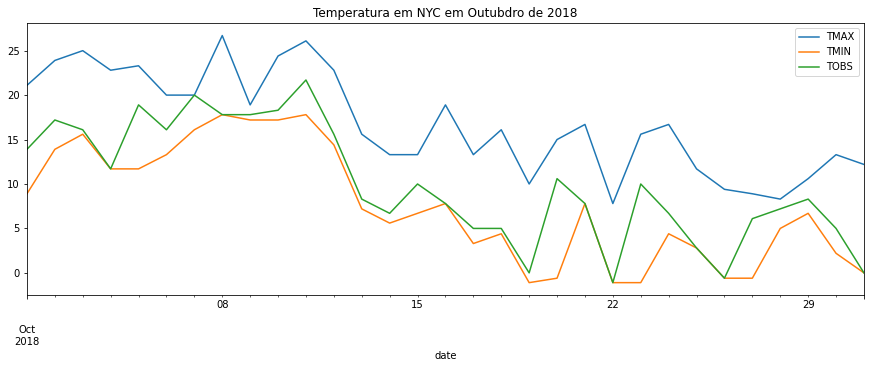

In [4]:
wide_df.plot(
    x='date', y = ['TMAX', 'TMIN', 'TOBS'], figsize=(15,5),
    title='Temperatura em NYC em Outubdro de 2018',
).set_label('Temperatura em Celsius')

plt.show()

#### Formato longo (_long format_)

Nesse tipo de formato, temos em cada linha uma observação de uma variável, ou seja, se nós temos três variáveis medidas diariamente, termos três linhas para cada dia registrado. Por esse motivo, o formato longo não é adequado para apresentar os dados.

In [5]:
# Carregamento de dados em formato longo
long_df = pd.read_csv('data/long_data.csv',
                      usecols=['date', 'datatype', 'value'],
                      parse_dates=['date']
)[['date', 'datatype', 'value']] # Ordenar colunas

long_df.head()

,date,datatype,value
0,2018-10-01,TMAX,21.1
1,2018-10-01,TMIN,8.9
2,2018-10-01,TOBS,13.9
3,2018-10-02,TMAX,23.9
4,2018-10-02,TMIN,13.9


Obter resumos estatísticos não funcionam corretamente com o formato longo:

In [6]:
long_df.describe(include='all', datetime_is_numeric=True)

,date,datatype,value
count,93,93,93.000000
unique,NaN,3,NaN
top,NaN,TMAX,NaN
freq,NaN,31,NaN
mean,2018-10-16 00:00:00,NaN,11.470968
min,2018-10-01 00:00:00,NaN,-1.100000
25%,2018-10-08 00:00:00,NaN,6.700000
50%,2018-10-16 00:00:00,NaN,11.700000
75%,2018-10-24 00:00:00,NaN,17.200000
max,2018-10-31 00:00:00,NaN,26.700000


Por outro lado, algumas visualizações gráficas são facilidadas com o formato longo:

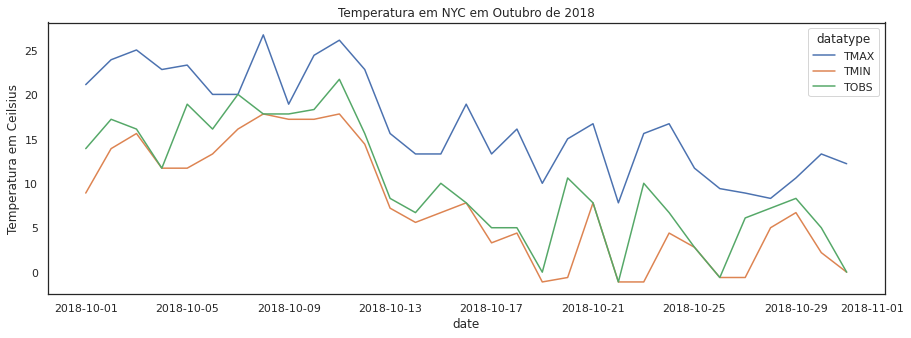

In [7]:
import seaborn as sns

sns.set(rc={'figure.figsize': (15,5)}, style='white')

ax = sns.lineplot(
    data = long_df, x = 'date', y = 'value', hue = 'datatype'
)

ax.set_ylabel('Temperatura em Ceilsius')
ax.set_title('Temperatura em NYC em Outubro de 2018')

plt.show()

O paâmetro `hue` permite colorir as linhas de acordo com uma os valores da coluna especidicada. Isso permite criar gráficos facetados com facilidade:

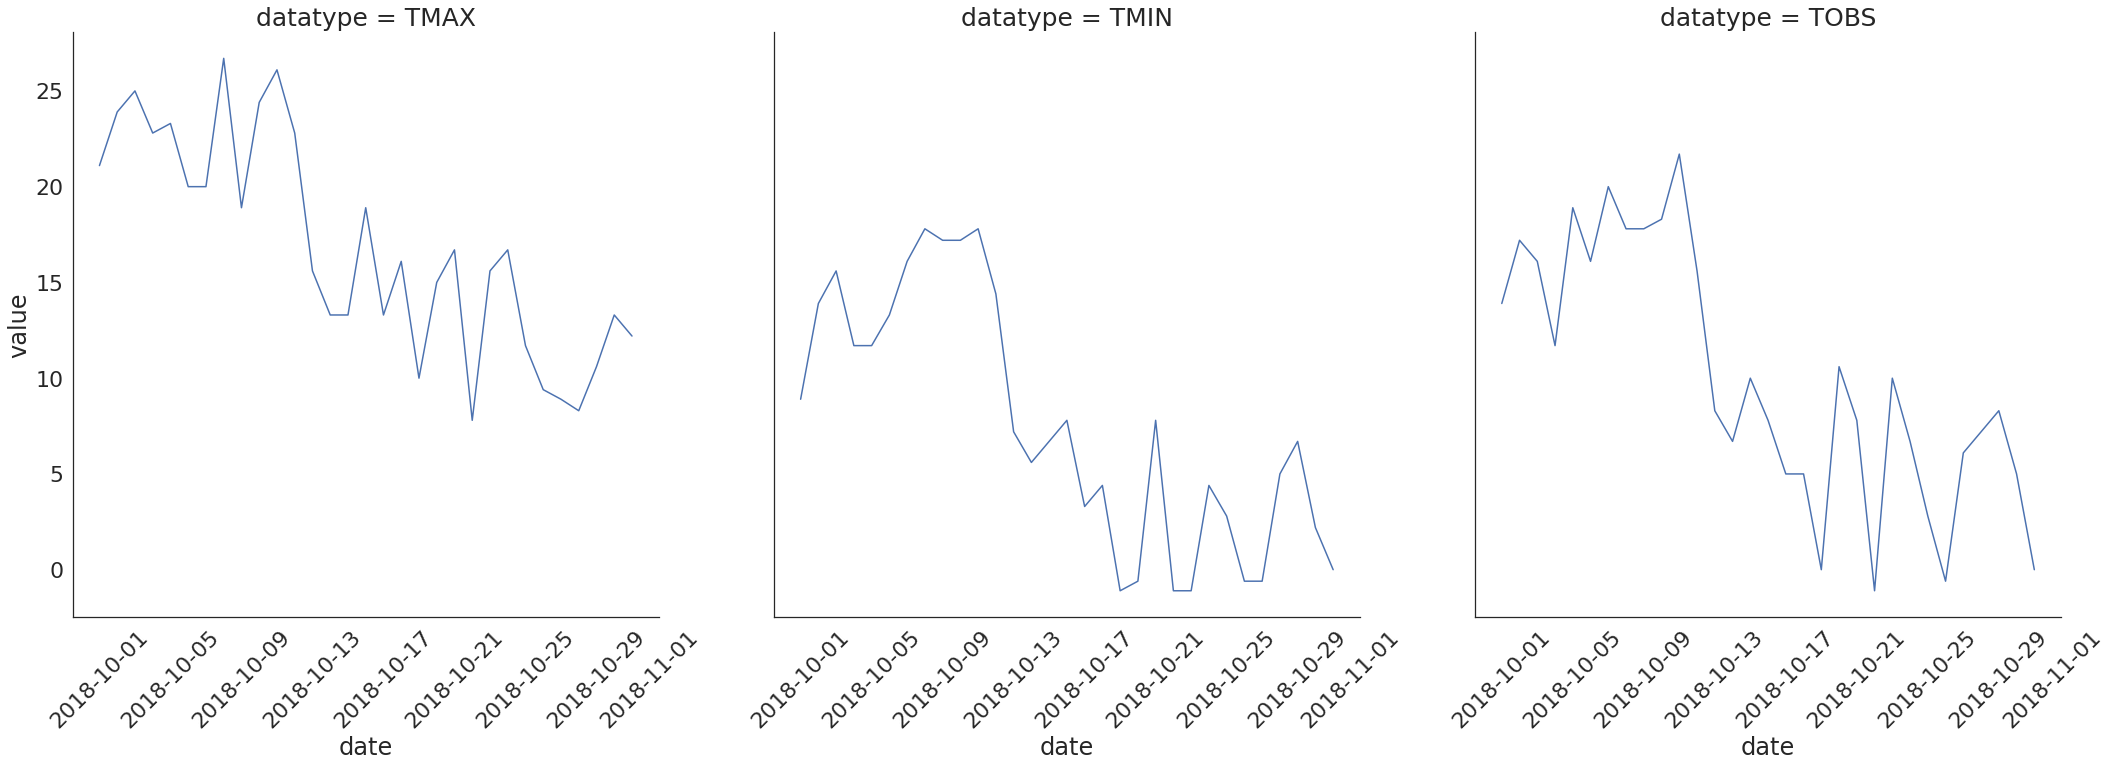

In [8]:
sns.set(
    rc={'figure.figsize': (20, 10)},
    style='white', font_scale=2
)
g = sns.FacetGrid(long_df, col='datatype', height=10)
g = g.map(plt.plot, 'date', 'value')
g.set_titles(size=25)
g.set_xticklabels(rotation=45)
plt.show()

## Explorar uma API para encontrar e coletar dados de temperatura

In [20]:
with open('../../.tokens/NCEI_API.txt') as f:
    TOKEN = f.readline()

In [9]:
import requests

In [22]:
def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the
    weather API passing headers ans optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload : A dictionary od a data to pass along
                    with the request.
    Returns:
        A response object.
    """
    return requests.get(
        'https://www.ncdc.noaa.gov/cdo-web/'
        f'api/v2/{endpoint}',
        headers={'token': TOKEN},
        params=payload
    )

In [23]:
response = make_request('datasets', {'startdate': '2018-10-01'})

In [24]:
response.status_code

200

In [25]:
response.ok

True

In [26]:
payload = response.json()
payload.keys()

dict_keys(['metadata', 'results'])

In [27]:
payload['metadata']

{'resultset': {'offset': 1, 'count': 11, 'limit': 25}}

In [28]:
payload['results'][0].keys()

dict_keys(['uid', 'mindate', 'maxdate', 'name', 'datacoverage', 'id'])

In [29]:
[(data['id'], data['name']) for data in payload['results']]

[('GHCND', 'Daily Summaries'),
 ('GSOM', 'Global Summary of the Month'),
 ('GSOY', 'Global Summary of the Year'),
 ('NEXRAD2', 'Weather Radar (Level II)'),
 ('NEXRAD3', 'Weather Radar (Level III)'),
 ('NORMAL_ANN', 'Normals Annual/Seasonal'),
 ('NORMAL_DLY', 'Normals Daily'),
 ('NORMAL_HLY', 'Normals Hourly'),
 ('NORMAL_MLY', 'Normals Monthly'),
 ('PRECIP_15', 'Precipitation 15 Minute'),
 ('PRECIP_HLY', 'Precipitation Hourly')]

In [30]:
response = make_request(
    'datacategories', payload={'datasetid': 'GHCND'}
)

In [31]:
response.status_code

200

In [32]:
response.json()['results']

[{'name': 'Evaporation', 'id': 'EVAP'},
 {'name': 'Land', 'id': 'LAND'},
 {'name': 'Precipitation', 'id': 'PRCP'},
 {'name': 'Sky cover & clouds', 'id': 'SKY'},
 {'name': 'Sunshine', 'id': 'SUN'},
 {'name': 'Air Temperature', 'id': 'TEMP'},
 {'name': 'Water', 'id': 'WATER'},
 {'name': 'Wind', 'id': 'WIND'},
 {'name': 'Weather Type', 'id': 'WXTYPE'}]

In [33]:
response = make_request(
    'datatypes',
    payload={'datacategoryid': 'TEMP', 'limit': 100}
)

In [34]:
response.status_code

200

In [35]:
[(datatype['id'], datatype['name']) for datatype in response.json()['results']]

[('CDSD', 'Cooling Degree Days Season to Date'),
 ('DATN',
  'Number of days included in the multiday minimum temperature (MDTN)'),
 ('DATX',
  'Number of days included in the multiday maximum temperature (MDTX)'),
 ('DLY-DUTR-NORMAL', 'Long-term averages of daily diurnal temperature range'),
 ('DLY-DUTR-STDDEV',
  'Long-term standard deviations of daily diurnal temperature range'),
 ('DLY-TAVG-NORMAL', 'Long-term averages of daily average temperature'),
 ('DLY-TAVG-STDDEV',
  'Long-term standard deviations of daily average temperature'),
 ('DLY-TMAX-NORMAL', 'Long-term averages of daily maximum temperature'),
 ('DLY-TMAX-STDDEV',
  'Long-term standard deviations of daily maximum temperature'),
 ('DLY-TMIN-NORMAL', 'Long-term averages of daily minimum temperature'),
 ('DLY-TMIN-STDDEV',
  'Long-term standard deviations of daily minimum temperature'),
 ('EMNT', 'Extreme minimum temperature for the period.'),
 ('EMXT', 'Extreme maximum temperature for the period.'),
 ('HDSD', 'Heating De

In [36]:
response = make_request(
    'locationcategories', payload={'datasetid': 'GHCND'}
)
response.status_code

200

In [37]:
import pprint
pprint.pprint(response.json())

{'metadata': {'resultset': {'count': 12, 'limit': 25, 'offset': 1}},
 'results': [{'id': 'CITY', 'name': 'City'},
             {'id': 'CLIM_DIV', 'name': 'Climate Division'},
             {'id': 'CLIM_REG', 'name': 'Climate Region'},
             {'id': 'CNTRY', 'name': 'Country'},
             {'id': 'CNTY', 'name': 'County'},
             {'id': 'HYD_ACC', 'name': 'Hydrologic Accounting Unit'},
             {'id': 'HYD_CAT', 'name': 'Hydrologic Cataloging Unit'},
             {'id': 'HYD_REG', 'name': 'Hydrologic Region'},
             {'id': 'HYD_SUB', 'name': 'Hydrologic Subregion'},
             {'id': 'ST', 'name': 'State'},
             {'id': 'US_TERR', 'name': 'US Territory'},
             {'id': 'ZIP', 'name': 'Zip Code'}]}


In [40]:
def get_item(name, what, endpoint, start=1, end=None):
    """
    Grab the JSON using binary search.
    Parameters:
        - name: The item to look for.
        - what: Dictionary specifying what item `name` is.
        - endpoint: Where to look for the item.
        - start: The position to start at. We don't need
                 to touch this, but the function will manipulate 
                 this with resursion.
        - end: The last position of the items. Used to
               find midpoint, but like `start` this is not
               something we need to worry ahout.
    Returns: Dictionary of the information for the item 
             if found, otherwise an empty dictionary.
    """
    # find the midpoint to cut the data in half each time
    mid = (start + (end or 1)) // 2
    
    # lowercase the name so this is not case-sensitive
    name = name.lower()
    
    # define the payload we will send with each request
    payload = {
        'datasetid': 'GHCND', 'sortfield': 'name',
        'offset': mid, # we'll chage the offset each time
        'limit': 1 # we only want one value back
    }
    
    # make request adding additional filters from `what`
    response = make_request(endpoint, {**payload, **what})
    
    if response.ok:
        payload = response.json()
        
        # if ok, grab the end index from the response
        # metadata the first time through
        end = end or payload['metadata']['resultset']['count']
        
        # grab the lowercase version of the current name
        current_name = payload['results'][0]['name'].lower()
        
        # if what we are searching for is in the curent
        # name, we have found our item
        if name in current_name:
            # return the found item
            return payload['results'][0]
        else:
            if start >= end:
                # if start index is greater the or equal
                # to end index, we couldm't find it
                return {}
            elif name < current_name:
                # name comes before the current name in the
                # alphabet => search further to the left
                return get_item(name, what, endpoint, start, mid - 1)
            elif name > current_name:
                # name comes after the current name in the
                # alphabet => search further to the right
                return get_item(name, what, endpoint, mid + 1, end)
            else:
                # response wasn't ok, use code to determine why
                print(f'Response not OK, status: {response.status_code}')

In [41]:
nyc = get_item(
    'New York', {'locationcategoryid': 'CITY'}, 'locations'
)

In [42]:
nyc

{'mindate': '1869-01-01',
 'maxdate': '2021-11-04',
 'name': 'New York, NY US',
 'datacoverage': 1,
 'id': 'CITY:US360019'}

In [43]:
central_park = get_item(
    'NY City Central Park',
    {'locationid': nyc['id']}, 'stations'
)

In [44]:
central_park

{'elevation': 42.7,
 'mindate': '1869-01-01',
 'maxdate': '2021-11-03',
 'latitude': 40.77898,
 'name': 'NY CITY CENTRAL PARK, NY US',
 'datacoverage': 1,
 'id': 'GHCND:USW00094728',
 'elevationUnit': 'METERS',
 'longitude': -73.96925}

In [45]:
response = make_request(
    'data',
    {'datasetid': 'GHCND',
     'stationid': central_park['id'],
     'locationid': nyc['id'],
     'startdate': '2018-10-01',
     'enddate': '2018-10-31',
     'datatypeid': ['TAVG', 'TMAX', 'TMIN'],
     'units': 'metric',
     'limit': 1000
    }
)

response.status_code

200

In [46]:
import pandas as pd

In [47]:
df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",24.4
1,2018-10-01T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",17.2
2,2018-10-02T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",25.0
3,2018-10-02T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",18.3
4,2018-10-03T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",23.3


In [48]:
df.datatype.unique()

array(['TMAX', 'TMIN'], dtype=object)

In [49]:
if get_item(
    'NY City Central Park',
    {'locationid': nyc['id'], 'datatypeid': 'TAVG'},
    'stations'
):
    print('Found!!')

Found!!


## Limpeza de Dados

In [56]:
import pandas as pd
df = pd.read_csv('data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


### Renomeando colunas

In [57]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

In [58]:
df.rename(
    columns={'value': 'temp_C', 'attributes': 'flags'}, inplace=True
)

In [59]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

In [60]:
df.loc[:, 'date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

In [61]:
df.describe(datetime_is_numeric=True)

,date,temp_C
count,93,93.000000
mean,2018-10-16 00:00:00,15.408602
min,2018-10-01 00:00:00,5.600000
25%,2018-10-08 00:00:00,10.200000
50%,2018-10-16 00:00:00,14.400000
75%,2018-10-24 00:00:00,21.100000
max,2018-10-31 00:00:00,27.800000
std,NaN,6.133703


In [62]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

In [63]:
new_df = df.assign(
    date = pd.to_datetime(df.date),
    temp_F = (df.temp_C * 9/5) + 32
)

In [64]:
new_df

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98
...,...,...,...,...,...,...
88,2018-10-30,TMAX,GHCND:USW00014732,",,W,2400",13.9,57.02
89,2018-10-30,TMIN,GHCND:USW00014732,",,W,2400",7.2,44.96
90,2018-10-31,TAVG,GHCND:USW00014732,"H,,S,",12.6,54.68
91,2018-10-31,TMAX,GHCND:USW00014732,",,W,2400",17.8,64.04


### Classificação e ordenamento de dados

In [67]:
sp = pd.read_csv(
    'data/sp500.csv', index_col='date', parse_dates=True
).drop(columns='adj_close')

In [68]:
sp.head()

,high,low,open,close,volume
date,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000


In [71]:
sp.assign(day_of_week=lambda x: x.index.day_name())

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
...,...,...,...,...,...,...
2018-12-24,2410.340088,2351.100098,2400.560059,2351.100098,2613930000,Monday
2018-12-26,2467.760010,2346.580078,2363.120117,2467.699951,4233990000,Wednesday
2018-12-27,2489.100098,2397.939941,2442.500000,2488.830078,4096610000,Thursday


In [72]:
bitcoin = pd.read_csv(
    'data/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])
bitcoin.head()

,open,high,low,close,volume
date,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008
2017-01-02,998.62,1031.39,996.70,1021.75,222184992
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008


In [74]:
# every day's closing price = S&P 500 close + Bitcoin close
# (same for other metrics)
portifolio = pd.concat([sp, bitcoin], sort=False).groupby(level='date').sum()

In [75]:
portifolio.head()

,high,low,open,close,volume
date,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008


### Tabelas Dinâmicas com Data Frames

In [77]:
pivoted_df = long_df.pivot(
    index='date', columns='datatype', values='value'
)
pivoted_df.head()

datatype,TMAX,TMIN,TOBS
date,,,
2018-10-01,21.1,8.9,13.9
2018-10-02,23.9,13.9,17.2
2018-10-03,25.0,15.6,16.1
2018-10-04,22.8,11.7,11.7
2018-10-05,23.3,11.7,18.9


In [78]:
pivoted_df.describe()

datatype,TMAX,TMIN,TOBS
count,31.000000,31.000000,31.000000
mean,16.829032,7.561290,10.022581
std,5.714962,6.513252,6.596550
min,7.800000,-1.100000,-1.100000
25%,12.750000,2.500000,5.550000
50%,16.100000,6.700000,8.300000
75%,21.950000,13.600000,16.100000
max,26.700000,17.800000,21.700000


In [79]:
pivoted_df = new_df.pivot(
    index='date', columns='datatype', values=['temp_C', 'temp_F']
)
pivoted_df.head()

temp_C             temp_F              
datatype     TAVG  TMAX  TMIN   TAVG   TMAX   TMIN
date                                              
2018-10-01   21.2  25.6  18.3  70.16  78.08  64.94
2018-10-02   22.7  26.1  19.4  72.86  78.98  66.92
2018-10-03   21.8  25.0  18.9  71.24  77.00  66.02
2018-10-04   21.3  26.1  17.8  70.34  78.98  64.04
2018-10-05   20.3  22.8  16.1  68.54  73.04  60.98

In [83]:
pivoted_df['temp_F']['TMIN'].describe()

count    31.000000
mean     53.989032
std      10.073151
min      42.080000
25%      44.960000
50%      48.920000
75%      64.490000
max      71.060000
Name: TMIN, dtype: float64

### Manipulando dados duplicados, faltantes, ou inválidos

In [84]:
import pandas as pd

In [85]:
df = pd.read_csv('data/dirty_data.csv')
df.head()

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
0,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
4,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False


In [94]:
df.describe().T

/home/igoandrade/anaconda3/envs/ds39/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
PRCP,765.0,5.360392,10.002138,0.0,0.00,0.0,5.8,61.7
SNOW,577.0,4.202773,25.086077,0.0,0.00,0.0,0.0,229.0
SNWD,577.0,NaN,NaN,-inf,NaN,NaN,NaN,inf
TMAX,765.0,2649.175294,2744.156281,-11.7,13.30,32.8,5505.0,5505.0
TMIN,765.0,-15.914379,24.242849,-40.0,-40.00,-11.1,6.7,23.9
TOBS,398.0,8.632161,9.815054,-16.1,0.15,8.3,18.3,26.1
WESF,11.0,16.290909,9.489832,1.8,8.60,19.3,24.9,28.7


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               765 non-null    object 
 1   station            765 non-null    object 
 2   PRCP               765 non-null    float64
 3   SNOW               577 non-null    float64
 4   SNWD               577 non-null    float64
 5   TMAX               765 non-null    float64
 6   TMIN               765 non-null    float64
 7   TOBS               398 non-null    float64
 8   WESF               11 non-null     float64
 9   inclement_weather  408 non-null    object 
dtypes: float64(7), object(3)
memory usage: 59.9+ KB


In [88]:
import numpy as np

In [89]:
df[df.inclement_weather == 'NaN'].shape[0]

0

In [90]:
df[df.inclement_weather == np.nan].shape[0]

0

In [91]:
df[df.inclement_weather.isna()].shape[0]

357

In [95]:
df[df.duplicated()].shape[0]

284

In [99]:
df.date = pd.to_datetime(df.date)

In [100]:
station_qm_wesf = df[df.station == '?'].drop_duplicates('date').set_index('date').WESF

In [101]:
df.sort_values('station', ascending=False, inplace=True)

In [102]:
df_depuded = df.drop_duplicates('date')

In [103]:
df_depuded = df_depuded.drop(columns='station').set_index('date').sort_index()
df_depuded.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2018-01-02,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
2018-01-03,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
2018-01-04,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
2018-01-05,14.2,127.0,inf,-4.4,-13.9,-13.9,NaN,True


In [104]:
df_depuded = df_depuded.assign(
    WESF = lambda x: x.WESF.combine_first(station_qm_wesf)
)

In [105]:
df_depuded.shape

(324, 8)

In [106]:
df_depuded.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2018-01-02,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
2018-01-03,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
2018-01-04,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
2018-01-05,14.2,127.0,inf,-4.4,-13.9,-13.9,NaN,True
